# Homework: The Perfect Market Maker
Robert Hatem

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from datetime import datetime
import time
%matplotlib inline

### Collecting trades and book data
These small datasets contain a trade book for April 4, 2018 and trades that occurred on that day. This small, manageable dataset is used to code the strategy, then it's applied on larger datasets. We aggregate all trades happening at the same time and same price, summing the order size. If there are multiple best ask/bids at one time point, then we used the last one, assuming the timestamping preserves order. We plot the best bid/ask and plot the trades that occur.

In [2]:
book = pd.read_csv('mkt_make_BTC_hw_small__book_lev_2.tab', sep='\t')
trades = pd.read_csv('mkt_make_BTC_hw_small__trades.tab', sep='\t')

The stragety's code

In [72]:
def simulate_trades(trades, book, s, j, k):
    # agg (sum) all trades happening
    #trades1 = trades.drop_duplicates(subset=['timestamp_utc_microseconds', 'Price']) 
    trades1 = trades.groupby(['timestamp_utc_microseconds', 'Price']).sum().reset_index()
    
    # current trade price. If multiple, keep only last row (per Piazza)
    book1 = book.drop_duplicates(subset=['timestamp_utc_microseconds'], keep='last')  
    book2 = book1.loc[:,['Ask1PriceMillionths', 'Ask1SizeBillionths', 'Bid1PriceMillionths', 'Bid1SizeBillionths', 'timestamp_utc_microseconds']]  # keep only best offers
    trades2 = pd.merge(left=trades1, right=book2, how='left', on=['timestamp_utc_microseconds'])  # left join on trades
    
    # convert to ones
    trades2.Ask1PriceMillionths = trades2.Ask1PriceMillionths * 1/(1e6)
    trades2.Ask1SizeBillionths = trades2.Ask1SizeBillionths * 1/(1e9)
    trades2.Bid1PriceMillionths = trades2.Bid1PriceMillionths * 1/(1e6)
    trades2.Bid1SizeBillionths = trades2.Bid1SizeBillionths * 1/(1e9)

    # rename cols
    trades2.rename(columns={'Ask1PriceMillionths':'Ask1Price', 'Ask1SizeBillionths':'Ask1Size', 'Bid1PriceMillionths':'Bid1Price', 'Bid1SizeBillionths':'Bid1Size'}, inplace=True)
    
    # readable date
    t = trades2.timestamp_utc_microseconds / 1e6
    trades2 = trades2.assign(time_of_day=t.apply(datetime.fromtimestamp))

    # at best price
    ask = trades2.Price == trades2.Ask1Price
    bid = trades2.Price == trades2.Bid1Price
    current_best_price = ask | bid
    trades2 = trades2.assign(ask=ask.astype(int))
    trades2 = trades2.assign(bid=bid.astype(int))
    trades2 = trades2.assign(cur_best_price=current_best_price.astype(int))

    # enough quantity to trade
    adequate_quantity = trades2.Size > 4*s
    trades2 = trades2.assign(ad_quant=adequate_quantity.astype(int))

    # initialize columns
    trades2 = trades2.assign(Trade=0, Position=0)
    
    # do first row
    trades2.iloc[0, trades2.columns.get_loc('Trade')] = (-trades2.iloc[0].ask*s + trades2.iloc[0].bid*s) * trades2.iloc[0].cur_best_price * trades2.iloc[0].ad_quant
    trades2.iloc[0, trades2.columns.get_loc('Position')] = trades2.iloc[0].Trade
    
    
    for index, row in trades.iloc[1:].iterrows():
        # cash flow
        new_trade = (-trades2.at[index, 'ask']*s + trades2.at[index, 'bid']*s) * trades2.at[index, 'cur_best_price'] * trades2.at[index, 'ad_quant']
        new_position = trades2.at[index-1, 'Position'] + new_trade
        
        do_trade = trades2.at[index, 'cur_best_price'] * trades2.at[index, 'ad_quant'] * (new_position >= -k) * (new_position <= j)  # stop-loss
        
        if do_trade:
            trades2.at[index, 'Trade'] = new_trade
            trades2.at[index, 'Position'] = new_position
        else:  # don't do trade
            new_position = trades2.at[index-1, 'Position']
            trades2.at[index, 'Position'] = new_position
                    
    cashflow = (trades2.Price * s * trades2.ask + trades2.Price * s * -trades2.bid) * trades2.ad_quant * (trades2.Trade!=0).astype(int)
    trades2 = trades2.assign(Cashflow=cashflow)
    trades2 = trades2.assign(Cash=cashflow.cumsum())
    
    trades3 = trades2.set_index('time_of_day')
    trade_ind = trades3.Trade != 0
    trade_color = (trades3.ask + 2*trades3.bid)*trade_ind
    trade_color1 = (trades3.ask * trade_ind).replace({0: np.nan}) * trades3.Price
    trade_color2 = (trades3.bid * trade_ind).replace({0: np.nan}) * trades3.Price
    trade_color3 = trade_ind.replace({1: np.nan, 0:1}) * trades3.Price
    
    trades3 = trades3.assign(trade_ind=trade_ind.astype(int))
    trades3 = trades3.assign(trade_color=trade_color)
    trades3 = trades3.assign(trade_color_ask=trade_color1)
    trades3 = trades3.assign(trade_color_bid=trade_color2)
    trades3 = trades3.assign(trade_color_intermediate=trade_color3)
    
    
    # remove rows that don't trade
    trades4 = trades3.loc[trades3.Trade!=0].copy()
    
    #trades3.at[-1, 'Trade'] = -trades3.Position[-1]
    #trades3.Position[-1] = 0
    #trades3.Cash[-1] = trades3.Trade[-1]*(trades3.Ask1Price[-1]+trades3.Bid1Price[-1])/2
    #trades3.trade_ind[-1] = int(trades3.Trade[-1] != 0)
    #trades3.trade_color_ask[-1] = np.nan
    #trades3.trade_color_bid[-1] = np.nan
    #trades3.trade_color_intermediate[-1] = np.nan
    final_cash = (trades3.Position[-2]/s)*(trades3.Ask1Price[-1]+trades3.Bid1Price[-1])/2 + trades3.Cash[-2]
    
    return trades3, final_cash #[cols]

In [73]:
t = time.process_time()

df, _ = simulate_trades(trades=trades, book=book, s=0.01, j=0.055, k=0.035)

print('Time on small dataset:',round(time.process_time() - t,3), 'seconds')

Time on small dataset: 0.132 seconds


In [5]:
def plot_market_maker(df1, before_trading=False, show_pnl=True, hide_trades=False):

    if not before_trading:
        colors = ['lawngreen', 'red', 'black']
        sizes = [30,10]
    else:
        colors = ['black', 'black', 'black']
        sizes = [10,10]
    
    if not hide_trades:
        fig, ax = plt.subplots(figsize=(10,8))
        plt.figure(1)
        plt.subplot(211)
        ax.ticklabel_format(useOffset=False)

        plt.plot(df1.index, df1.Bid1Price, linewidth=1.0, label='Bid')
        plt.plot(df1.index, df1.Ask1Price, linewidth=1.0, label='Ask')
        plt.scatter(x=df1.index, y=df1.trade_color_bid, s=sizes[0], c=colors[0], label='Purchase', alpha=1)
        plt.scatter(x=df1.index, y=df1.trade_color_ask, s=sizes[0], c=colors[1], label='Sale', alpha=1)
        plt.scatter(x=df1.index, y=df1.trade_color_intermediate, s=sizes[1], c=colors[2], label='No transaction for MM')

        plt.legend()
        plt.ylabel('Price of Transaction')
        plt.xlabel('Time of Day')
        plt.show()

    if show_pnl:
        plt.subplots(figsize=(10,8))
        plt.subplot(212)
        plt.plot(df1.Cash, '.-',linewidth=1)
        plt.ylabel('Cash')
        plt.xlabel('Time of Day')
        plt.legend(['PnL'])

Let's plot the book and trades. From the book, we plot only the best bid/ask, not the second-best or third-best bids/asks. For the trades, these are trades that executed.

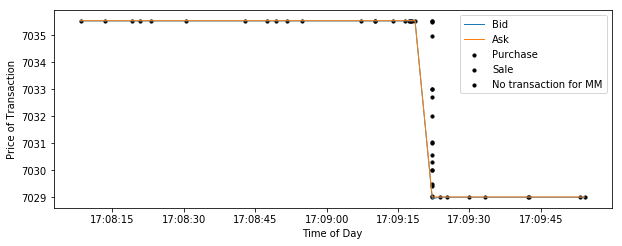

In [7]:
start = 0
end = 47
df1 = df.iloc[start:end,:]
plot_market_maker(df1, before_trading=True, show_pnl=False)

The plot shows the best bid price (blue) and best ask price (orange) over time. It Also shows the trades that actually occured (black). Many of the trades are at, or near, the best bid or best ask price; they lie on the orange or blue lines. However, some trades were not at the best bid/ask price. For example, the floating black dots after the bid/ask fell were executed at higher prices even after the bid/ask fell.  

For the perfect market maker (PMM), he must decide which of trades he wishes he had executed. The PMM would only enter trades that were at the best bid/ask and sufficiently large order size. This perfect market maker is a backward looking test; it cannot be implemented going forward since it requires clairvoyance. This strategy is simply for analysis, not for suggesting profitable trading strategies.  

Let's zoom in on the first few trades.

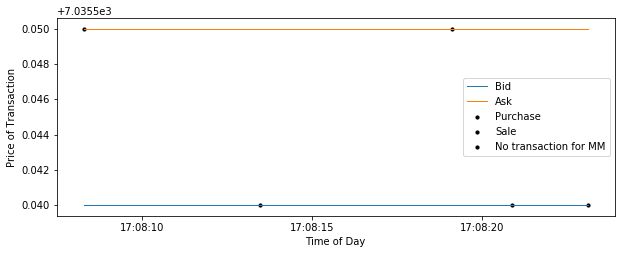

In [222]:
plot_market_maker(df1[0:5], before_trading=True, show_pnl=False)

All of these trades appear to be at the best ask/best bid price. Therefore, we expect our simulated perfect market maker will have particiated in these trades, assuming they have sufficient order size. Let's view the strategy and see which trades the PMM particupates in.

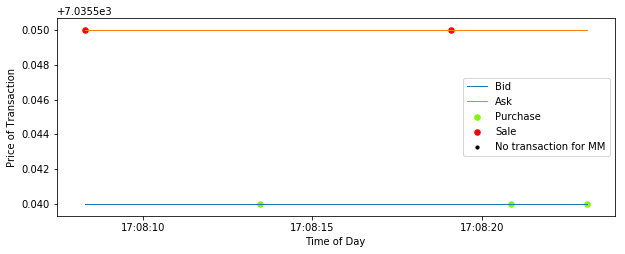

In [223]:
plot_market_maker(df1[0:5], before_trading=False, show_pnl=False)

Indeed, the PMM participated in all five of these trades (i.e. no black dots). Notice the PMM first sells at 7035.55 USD, then buys at 7035.54 USD, then sells again at 7035.55 USD, and so on. It bought low and sold high. Now let see the corresponding PnL.

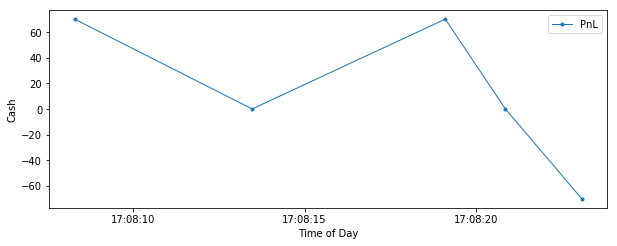

In [224]:
plot_market_maker(df1[0:5], before_trading=False, show_pnl=True, hide_trades=True)

After the first trade, the strategy is up 70.3555 (0.01*7035.55=quantity times price) since it sold the asset. In the second trade, it bought the asset but at a lower price (7035.54), and cash dropped to 0.01 which is the difference between the buy and sell prices. After the fourth trade, the cash is up to 0.02 USD. Each buy-sell pair should give the spread value (in real life it's half the spread).  

Let's zoom out and view the first dozen trades.

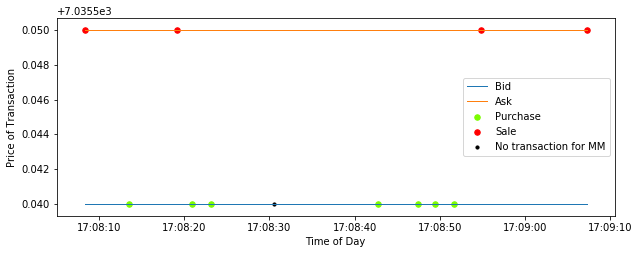

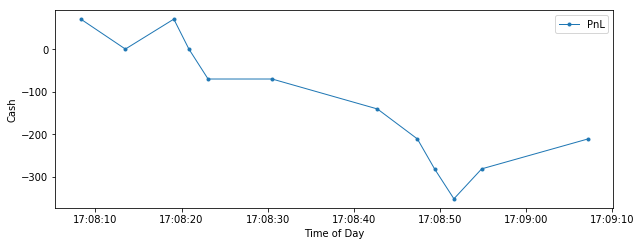

In [225]:
plot_market_maker(df1[0:12], before_trading=False, show_pnl=True, hide_trades=False)

Our market maker did not participate in the sixth trade (black dot) since the quantity was too small. Therefore, PnL is flat over that non-trade. The final PnL is negative because the strategy has a net long positions after 12 trades. At the end of the strategy, the PMM will sell it's long position thus raising the final PnL.  

Now, zoom in where the best asks/bids change instead of remainng constant. This takes us to trade ~20 out of 47.

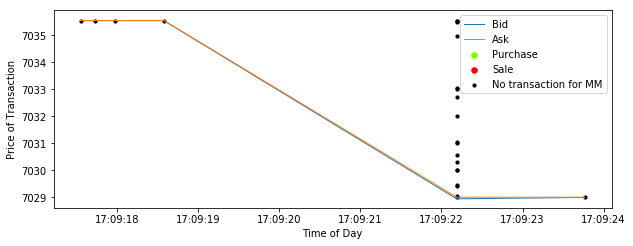

In [226]:
plot_market_maker(df1[17:40], before_trading=False, show_pnl=False, hide_trades=False)
#df1[17:39]

The PMM did not enter into the first four trades because of the stop loss. The PMM was already deep long and those four trades were all bids to buy. After the dropped, there were 18 trades at one time point, but only one was at the best bid/ask, while 17 were at different prices. The one trade was a sale, so it would avoid the stop-loss, but the quantity was too small to execute. So was the rightmost trade. So the PMM did no trades in this time interval. Note that the best bid/ask prices are only plotted at times where trades occurred.  

The PnL for this time interval is constant since no trades occurred:

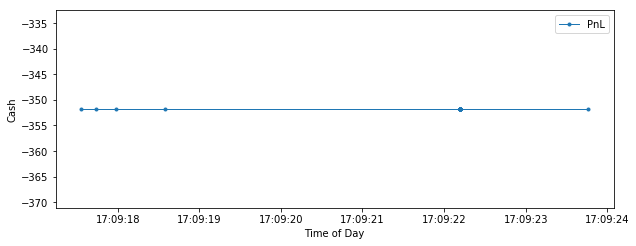

In [227]:
plot_market_maker(df1[17:40], before_trading=False, show_pnl=True, hide_trades=True)

Let's take one final look at the strategy's trades for the small file.

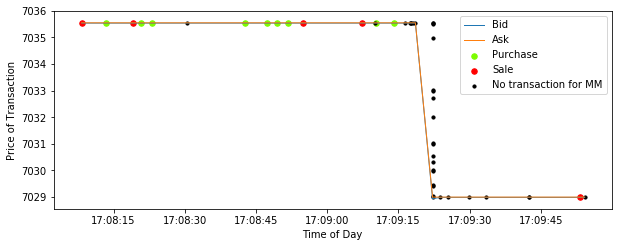

In [228]:
plot_market_maker(df1[0:], before_trading=False, show_pnl=False, hide_trades=False)

Now that the PMM strategy is working on the small file, let's apply it to larger data files.

## Large files (2018 and 2019)

In [8]:
book18 = pd.read_csv('mkt_make_BTC_hw_big__book_lev_2.tab', sep='\t')
trades18 = pd.read_csv('mkt_make_BTC_hw_big__trades.tab', sep='\t')

In [74]:
t = time.process_time()

df2, PnL2 = simulate_trades(trades=trades18, book=book18, s=0.01, j=0.055, k=0.035)

print('Time to run for big 2018 file:',round(time.process_time() - t,3), 'seconds')

Time to run for big 2018 file: 7.075 seconds


Lets plot the trades on a larger dataset from April 8-9, 2018.

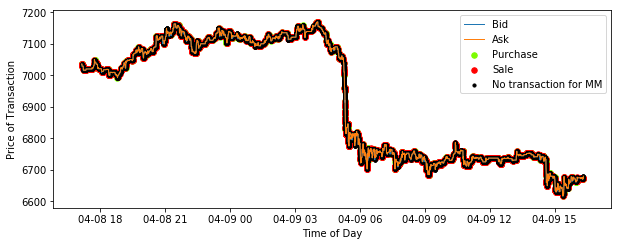

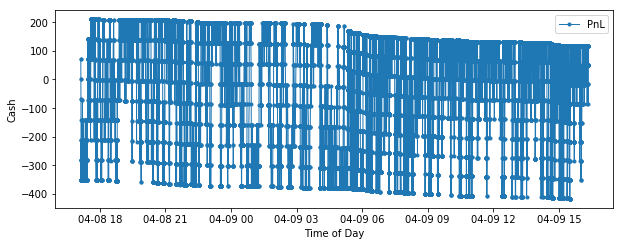

In [75]:
plot_market_maker(df2[0:], before_trading=False, show_pnl=True, hide_trades=False)

Zoom in on the first trades.

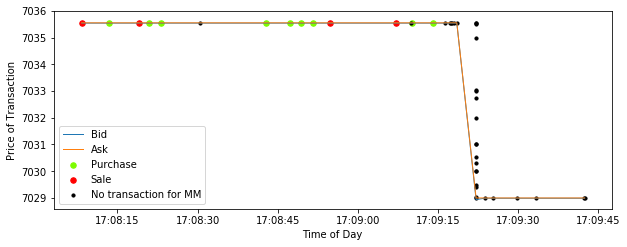

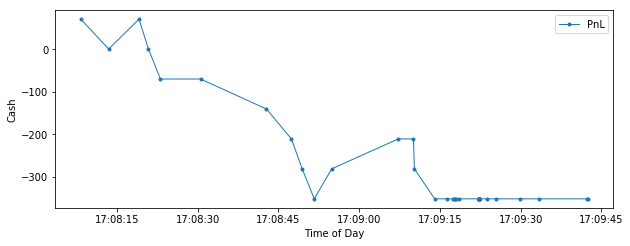

In [83]:
plot_market_maker(df2[0:45], before_trading=False, show_pnl=True, hide_trades=False)

As before, the stragety reaches its maximum long position and must stop trading. Since the PMM must buy the asset to enter the long position, the PnL is negative after this short stretch. Again, there is a drop of best bid/ask, which the PMM does not participate in.  

Now let's zoom out to a bigger time window.

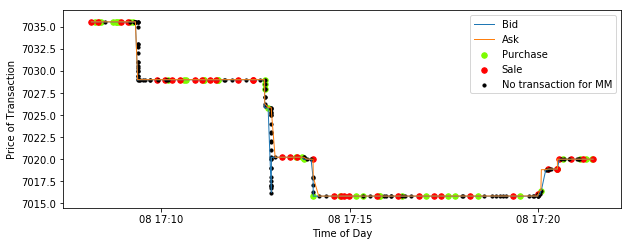

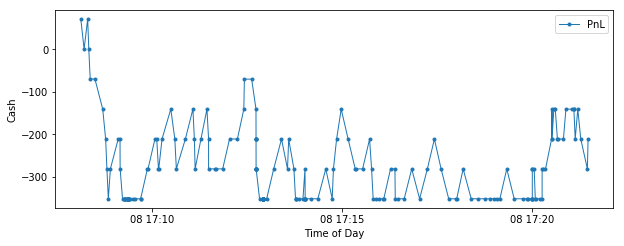

In [84]:
plot_market_maker(df2[0:200], before_trading=False, show_pnl=True, hide_trades=False)

Again, the stragy lives mostly in a long position, resulting in negative PnL. However, after some time, the strategy returns to a neutral position.

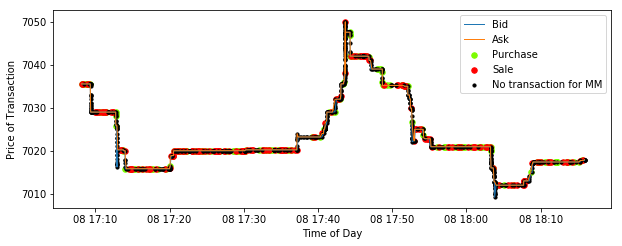

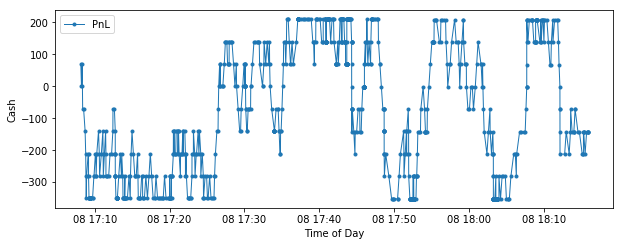

In [89]:
plot_market_maker(df2[0:1000], before_trading=False, show_pnl=True, hide_trades=False)

The PnL rises and falls below zero based on the net long/short position it is currently occupying. To get a sense of gains, we filter to only positions which are neutral.

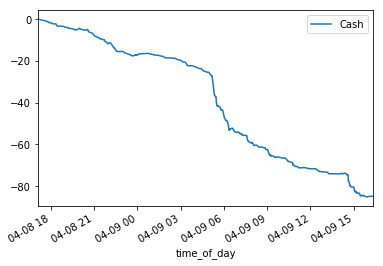

In [116]:
df2.loc[abs(df2.Position) < 1e-15].Cash.plot();
plt.legend();

This PnL at neutral positions shows a steady loss of cash. This is surprising; a steady rise of cash is expected. One possible explanation is a bug in the code like a flipped sign. Another idea is that the strategy builds up large short or large long positions then the price moves unfavorably, then the strategy unwinds the positions. However, it seems unlikely that the price would consistently move against us.

Now for big data from 2/16/2019.

In [135]:
book19 = pd.read_csv('mkt_make_BTC_hw_big_2019__book_lev_2.tab', sep='\t')
trades19 = pd.read_csv('mkt_make_BTC_hw_big_2019__trades.tab', sep='\t')

trades19.rename(columns={"price": "Price", "size": "Size"}, inplace=True)
trades19.timestamp_utc_microseconds = trades19.timestamp_utc_microseconds.astype('int64')
book19.rename(columns={"timestamp_utc_microseconds": "timestamp_utc_microseconds_old"}, inplace=True)
book19.rename(columns={"received_utc_microseconds": "timestamp_utc_microseconds"}, inplace=True)

In [142]:
t = time.process_time()

df3, _ = simulate_trades(trades=trades19, book=book19, s=0.01, j=0.055, k=0.035)

print(round(time.process_time() - t,3), 'seconds')

4.16 seconds


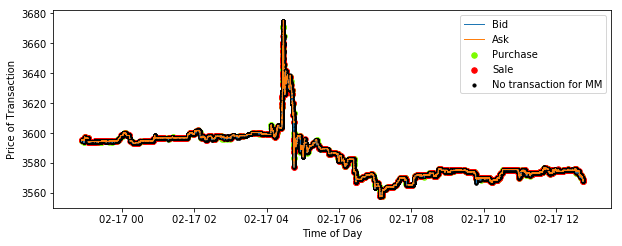

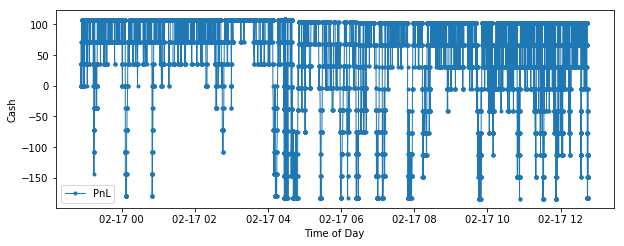

In [143]:
plot_market_maker(df3, before_trading=False, show_pnl=True, hide_trades=False)

The price has a big spike in the middle of the day. The PnL makes almost-discrete jumps based for each trade, and the PnL again fluctuates around zero based on whether the position is net long or short.  The plot is bright orange because of the many overlapping trade points.

Let's check the PnL for times with a neutral position.

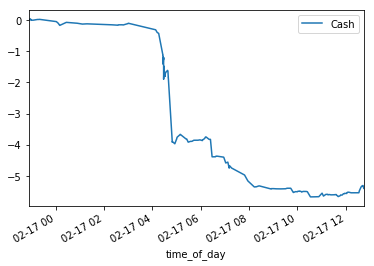

In [151]:
df3.loc[abs(df3.Position) < 1e-15].Cash.plot();
plt.legend();

Again, this strategy loses money pretty consistently. Maybe this is a feature of our perfect market maker strategy.

Now let's run a grid search of the parameters to see how they affect the final realized PnL.

## Grid Search
s, j, k

s: 0.000500, j: 0.001000, k: 0.001000, time: 4.328000, final_cash: -7132.704330
s: 0.000500, j: 0.001000, k: 0.030000, time: 4.575000, final_cash: -142649.350710
s: 0.000500, j: 0.010000, k: 0.001000, time: 4.906000, final_cash: 39227.891465
s: 0.000500, j: 0.010000, k: 0.030000, time: 4.242000, final_cash: -142649.523150
s: 0.010000, j: 0.001000, k: 0.001000, time: 4.559000, final_cash: 0.000000
s: 0.010000, j: 0.001000, k: 0.030000, time: 4.211000, final_cash: -10599.470400
s: 0.010000, j: 0.010000, k: 0.001000, time: 4.430000, final_cash: -1.066800
s: 0.010000, j: 0.010000, k: 0.030000, time: 3.990000, final_cash: -10599.470400
s: 0.020000, j: 0.001000, k: 0.001000, time: 4.387000, final_cash: 0.000000
s: 0.020000, j: 0.001000, k: 0.030000, time: 3.952000, final_cash: -3498.444800
s: 0.020000, j: 0.010000, k: 0.001000, time: 3.787000, final_cash: 0.000000
s: 0.020000, j: 0.010000, k: 0.030000, time: 3.793000, final_cash: -3498.444800
s: 0.100000, j: 0.001000, k: 0.001000, time: 3.78

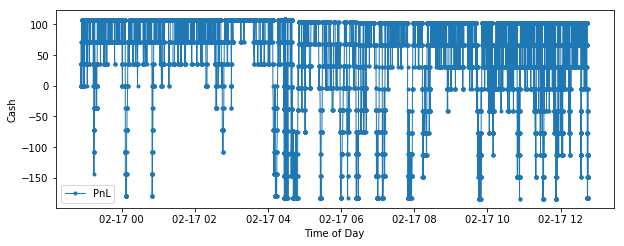

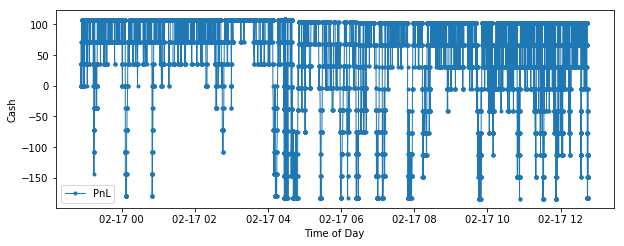

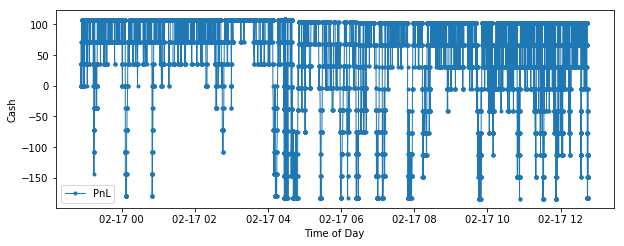

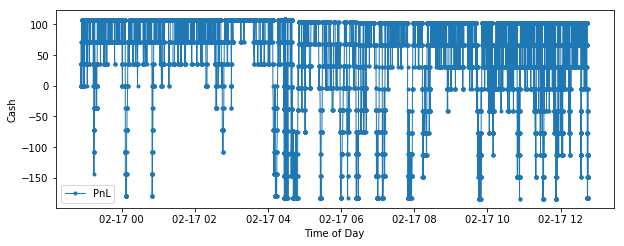

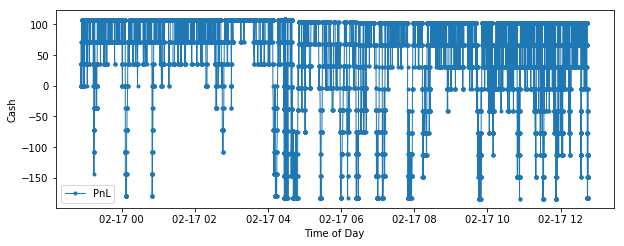

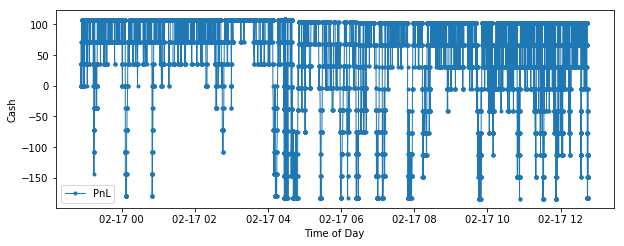

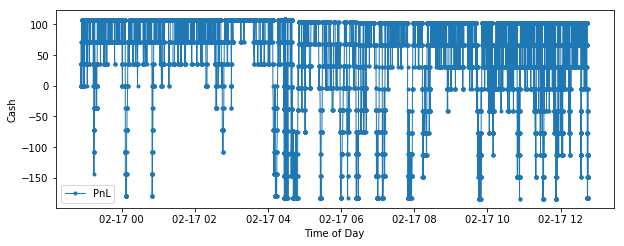

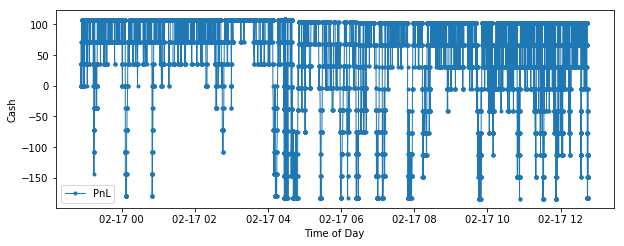

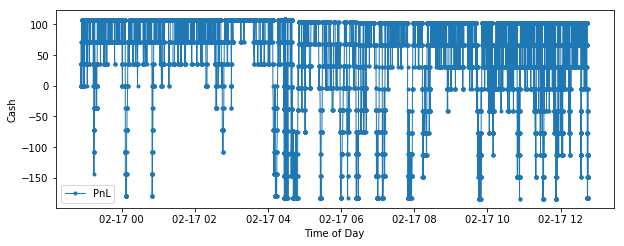

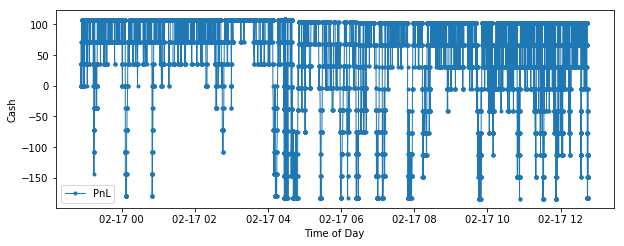

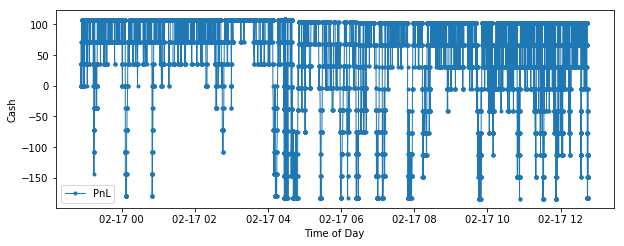

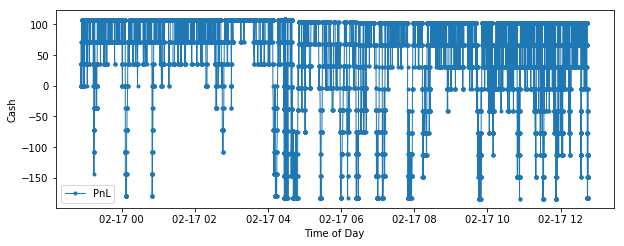

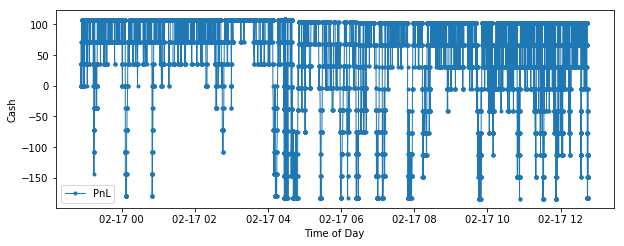

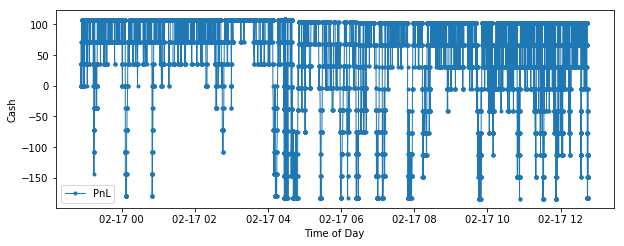

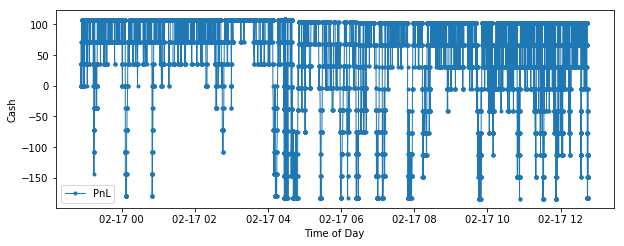

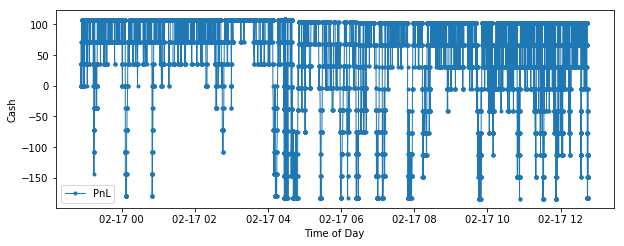

In [191]:
s_vals = [0.0005, 0.01, 0.02, 0.1]
j_vals = [0.001, 0.01]
k_vals = [0.001, 0.03]

results ={'s':[], 'j':[], 'k':[], 'final_cash':[]}

s_max, j_max, k_max, cash_max = 0, 0, 0, 0

for s in s_vals:
    for j in j_vals:
        for k in k_vals:
            t = time.process_time()
            df1, final_cash = simulate_trades(trades=trades19, book=book19, s=s, j=j, k=k)
            t_final = round(time.process_time() - t,3)

            #if df1.shape[0]!=0:
                #final_cash = df1.Cash[-1]
            #else:
                #final_cash = 0
            
            results['s'].append(s)
            results['j'].append(j)
            results['k'].append(k)
            results['final_cash'].append(final_cash)
            print("s: %f, j: %f, k: %f, time: %f, final_cash: %f" % (s,j,k,t_final,final_cash))
            plot_market_maker(df3, before_trading=False, show_pnl=True, hide_trades=True)

df_grid = pd.DataFrame(data=results)

#print('Param with max final cash',df_grid.final_cash.idxmax())
#df_grid.iloc[40:43,:]


In [201]:
df_grid

,s,j,k,final_cash
0,0.0005,0.001,0.001,-7132.704330
1,0.0005,0.001,0.030,-142649.350710
2,0.0005,0.010,0.001,39227.891465
3,0.0005,0.010,0.030,-142649.523150
4,0.0100,0.001,0.001,0.000000
5,0.0100,0.001,0.030,-10599.470400
6,0.0100,0.010,0.001,-1.066800
7,0.0100,0.010,0.030,-10599.470400
8,0.0200,0.001,0.001,0.000000
9,0.0200,0.001,0.030,-3498.444800


On our simple grid search, there were mostly net losses, some zeros, and only one combination with a net gain. Let's look at s=1, which gave net zero for each parameter combination.

In [202]:
t = time.process_time()

df4, _ = simulate_trades(trades=trades19, book=book19, s=0.1, j=0.01, k=0.03)

print(round(time.process_time() - t,3), 'seconds')

5.448 seconds


In [214]:
print('Number of possible trades with adequate order size:', df4.ad_quant.sum(), 'out of', df4.shape[0])

Number of possible trades with adequate order size: 1621 out of 18209


The trade size setting s=0.1 was so large that almost no possible trades were big enough to participate in.  

In [218]:
print('Number of trades participated in:',df4.loc[df4.Trade != 0].shape[0])

Number of trades participated in: 0


Now let's look at the strategy that made money.

In [221]:
t = time.process_time()
df5, _ = simulate_trades(trades=trades19, book=book19, s=0.0005, j=0.01, k=0.001)
print(round(time.process_time() - t,3), 'seconds')

4.345 seconds


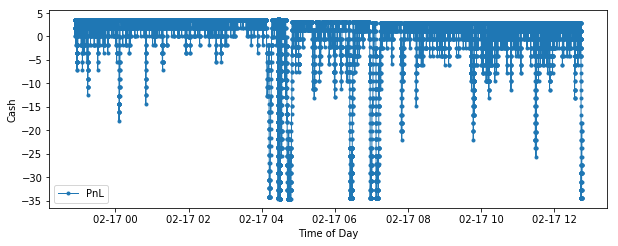

In [223]:
# plot PnL
plot_market_maker(df5, before_trading=False, show_pnl=True, hide_trades=True)

The PnL shows the strategy can take much larger long positions (negative cash) than short positions, due to **j=0.01** and **k=0.001**.

Let's return to the grid search and look at the parameters and their final PnLs.

In [228]:
df_grid

,s,j,k,final_cash
0,0.0005,0.001,0.001,-7132.704330
1,0.0005,0.001,0.030,-142649.350710
2,0.0005,0.010,0.001,39227.891465
3,0.0005,0.010,0.030,-142649.523150
4,0.0100,0.001,0.001,0.000000
5,0.0100,0.001,0.030,-10599.470400
6,0.0100,0.010,0.001,-1.066800
7,0.0100,0.010,0.030,-10599.470400
8,0.0200,0.001,0.001,0.000000
9,0.0200,0.001,0.030,-3498.444800


The only combination with positive final PnL has very small k, i.e. the strategy is limited to only small short positions. Allowing large short positions results in larger losses for every combination. The max long position, on the other hand, seems to matter less for final PnL.  

On average, this strategy does not indicate strong returns as currently constructed as the final PnLs are mostly negative.